 Rakshana B S RB5118



 Please note: In the following code assignment, I have replaced the variables as per the homework instructions.
- 'B' refers to 'original_badnet'.
- 'G' refers to 'RepairedNet'.

 This naming convention aligns with the instructions for clarity and consistency.


In [1]:
# All necessary imports
import os
import tarfile
import requests
import re
import sys
import warnings
warnings.filterwarnings('ignore')
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as font_manager
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [3]:
# Load data
def load_dataset(file_path):
    # Open the file in read mode
    dataset = h5py.File(file_path, 'r')
    # Extract the 'data' and 'label' elements
    images = np.array(dataset['data'])
    labels = np.array(dataset['label'])
    # Rearrange the dimensions of the image data for processing
    images = images.transpose((0,2,3,1))
    # Return the image and label data
    return images, labels

In [4]:
# Define file paths for the datasets and model files
# Path to the clean validation data
valid_clean_data_path = '/content/drive/MyDrive/ColabNotebooks/rb5118_backdoor/Lab3/cl/valid.h5'
# Path to the clean test data
test_clean_data_path = '/content/drive/MyDrive/ColabNotebooks/rb5118_backdoor/Lab3/cl/test.h5'
# Path to the poisoned (backdoored) test data
test_poisoned_data_path = '/content/drive/MyDrive/ColabNotebooks/rb5118_backdoor/Lab3/bd/bd_test.h5'
# Path to the model file (architecture)
network_model_path = '/content/drive/MyDrive/ColabNotebooks/rb5118_backdoor/Lab3/models/bd_net.h5'
# Path to the model weights
network_weights_path = '/content/drive/MyDrive/ColabNotebooks/rb5118_backdoor/Lab3/models/bd_weights.h5'


In [5]:
# Load the datasets using the modified data loading function

# Load clean validation data
cl_valid_images, cl_valid_labels = load_dataset(valid_clean_data_path)

# Load clean test data
cl_test_images, cl_test_labels = load_dataset(test_clean_data_path)

# Load poisoned (backdoored) test data
bd_test_images, bd_test_labels = load_dataset(test_poisoned_data_path)

In [6]:
from tensorflow import keras

# Load the original BadNet model and its weights
original_badnet = keras.models.load_model(network_model_path)
original_badnet.load_weights(network_weights_path)

# Create a clone of the original BadNet model
badnet_clone = keras.models.load_model(network_model_path)
badnet_clone.load_weights(network_weights_path)


In [7]:

from tensorflow.keras import backend as K

# Calculate the accuracy of the original BadNet model on clean validation data
# Predict labels for clean validation data using the original badnet
predicted_labels = np.argmax(original_badnet.predict(cl_valid_images), axis=1)
# Calculate the accuracy by comparing the predicted labels with true labels
accuracy_clean = np.mean(np.equal(predicted_labels, cl_valid_labels)) * 100

# Print the clean validation accuracy before pruning
print("Clean validation accuracy before pruning: {:.6f}".format(accuracy_clean))

# Clear the Keras session to free up resources
K.clear_session()


361/361 [==============================] - 9s 3ms/step
Clean validation accuracy before pruning: 98.649000


In [8]:
from tensorflow.keras.models import Model

# Redefine the model to output right after the last pooling layer ("pool_3")
pool3_output_model = Model(inputs=original_badnet.inputs, outputs=original_badnet.get_layer('pool_3').output)

# Obtain feature map for the last pooling layer using clean validation data
pool3_feature_maps = pool3_output_model.predict(cl_valid_images)

# Compute average activation value for each channel in the pooling layer
avg_activation_values = np.mean(pool3_feature_maps, axis=(0,1,2))

# Sort the indices of the channels based on their average activation values in increasing order
channels_for_pruning = np.argsort(avg_activation_values)

# Extract weights and biases of the third convolutional layer from the cloned model
conv3_weights, conv3_biases = badnet_clone.layers[5].get_weights()

# Initialize a variable to track which models have been saved
models_saved = np.zeros(3, dtype=bool)

# Iterate over each channel index for pruning
for channel_index in channels_for_pruning:
    # Set the weights and biases of the selected channel to zero (prune the channel)
    conv3_weights[:,:,:,channel_index] = 0
    conv3_biases[channel_index] = 0

    # Update the cloned model with the modified weights and biases
    badnet_clone.layers[5].set_weights([conv3_weights, conv3_biases])

    # Evaluate the cloned model's accuracy on clean validation data
    predicted_labels_valid = np.argmax(badnet_clone.predict(cl_valid_images), axis=1)
    current_accuracy_valid = np.mean(np.equal(predicted_labels_valid, cl_valid_labels)) * 100

    # Check for accuracy drops at thresholds of 2%, 4%, and 10%, and save the model accordingly
    if accuracy_clean - current_accuracy_valid >= 2 and not models_saved[0]:
        print("The accuracy drops at least 2%, saved the model")
        badnet_clone.save('model_X=2.h5')
        models_saved[0] = 1
    if accuracy_clean - current_accuracy_valid >= 4 and not models_saved[1]:
        print("The accuracy drops at least 4%, saved the model")
        badnet_clone.save('model_X=4.h5')
        models_saved[1] = 1
    if accuracy_clean - current_accuracy_valid >= 10 and not models_saved[2]:
        print("The accuracy drops at least 10%, saved the model")
        badnet_clone.save('model_X=10.h5')
        models_saved[2] = 1
        break


361/361 [==============================] - 1s 2ms/step
The accuracy drops at least 2%, saved the model
361/361 [==============================] - 1s 2ms/step
The accuracy drops at least 4%, saved the model
361/361 [==============================] - 1s 3ms/step
The accuracy drops at least 10%, saved the model


In [9]:
import tensorflow as tf
import numpy as np

class RepairedNet(tf.keras.Model):
    def __init__(self, original_net, pruned_net):
        super(RepairedNet, self).__init__()
        self.original_net = original_net
        self.pruned_net = pruned_net

    def predict(self, data):
        # Predictions from the original and pruned networks
        prediction_original = np.argmax(self.original_net(data), axis=1)
        prediction_pruned = np.argmax(self.pruned_net(data), axis=1)
        # Compare predictions, output original if they match, else output 1283
        combined_predictions = np.array([prediction_original[i] if prediction_original[i] == prediction_pruned[i] else 1283 for i in range(prediction_original.shape[0])])
        # Convert to categorical format
        categorical_output = np.zeros((prediction_original.shape[0], 1284))
        categorical_output[np.arange(combined_predictions.size), combined_predictions] = 1
        return categorical_output

    def call(self, data):
        # Similar logic as predict, but used for batch processing and faster execution
        prediction_original = np.argmax(self.original_net(data), axis=1)
        prediction_pruned = np.argmax(self.pruned_net(data), axis=1)
        combined_predictions = np.array([prediction_original[i] if prediction_original[i] == prediction_pruned[i] else 1283 for i in range(prediction_original.shape[0])])
        categorical_output = np.zeros((prediction_original.shape[0], 1284))
        categorical_output[np.arange(combined_predictions.size), combined_predictions] = 1
        return categorical_output


In [10]:
from tensorflow import keras

# Define file paths for the B_prime models with different levels of pruning
pruned_model_2_path = '/content/model_X=2.h5'
pruned_model_4_path = '/content/model_X=4.h5'
pruned_model_10_path = '/content/model_X=10.h5'

# Load the pruned models corresponding to different pruning thresholds
pruned_net_2_percent = keras.models.load_model(pruned_model_2_path)
pruned_net_4_percent = keras.models.load_model(pruned_model_4_path)
pruned_net_10_percent = keras.models.load_model(pruned_model_10_path)


In [11]:
# Evaluate the B_prime model with 2% threshold on clean and backdoored test data

# Predict and calculate accuracy on clean test data using B_prime model (2% threshold)
predicted_labels_clean_2 = np.argmax(pruned_net_2_percent.predict(cl_test_images), axis=1)
accuracy_clean_2 = np.mean(np.equal(predicted_labels_clean_2, cl_test_labels)) * 100
print('Clean Classification accuracy for B_prime with 2% pruning:', accuracy_clean_2)

# Predict and calculate the attack success rate on backdoored test data using B_prime model (2% threshold)
predicted_labels_bd_2 = np.argmax(pruned_net_2_percent.predict(bd_test_images), axis=1)
attack_success_rate_2 = np.mean(np.equal(predicted_labels_bd_2, bd_test_labels)) * 100
print('Attack Success Rate for B_prime with 2% pruning:', attack_success_rate_2)


401/401 [==============================] - 1s 3ms/step
Clean Classification accuracy for B_prime with 2% pruning: 95.90023382696803
401/401 [==============================] - 1s 2ms/step
Attack Success Rate for B_prime with 2% pruning: 100.0


In [12]:
# Evaluate the B_prime model with 4% threshold on clean and backdoored test data

# Predict and calculate accuracy on clean test data using B_prime model (4% threshold)
predicted_labels_clean_4 = np.argmax(pruned_net_4_percent.predict(cl_test_images), axis=1)
accuracy_clean_4 = np.mean(np.equal(predicted_labels_clean_4, cl_test_labels)) * 100
print('Clean Classification accuracy for B_prime with 4% pruning:', accuracy_clean_4)

# Predict and calculate the attack success rate on backdoored test data using B_prime model (4% threshold)
predicted_labels_bd_4 = np.argmax(pruned_net_4_percent.predict(bd_test_images), axis=1)
attack_success_rate_4 = np.mean(np.equal(predicted_labels_bd_4, bd_test_labels)) * 100
print('Attack Success Rate for B_prime with 4% pruning:', attack_success_rate_4)


401/401 [==============================] - 1s 2ms/step
Clean Classification accuracy for B_prime with 4% pruning: 92.29150428682775
401/401 [==============================] - 1s 2ms/step
Attack Success Rate for B_prime with 4% pruning: 99.98441153546376


In [13]:
# Evaluate the B_prime model with 10% threshold on clean and backdoored test data

# Predict and calculate accuracy on clean test data using B_prime model (10% threshold)
predicted_labels_clean_10 = np.argmax(pruned_net_10_percent.predict(cl_test_images), axis=1)
accuracy_clean_10 = np.mean(np.equal(predicted_labels_clean_10, cl_test_labels)) * 100
print('Clean Classification accuracy for B_prime with 10% pruning:', accuracy_clean_10)

# Predict and calculate the attack success rate on backdoored test data using B_prime model (10% threshold)
predicted_labels_bd_10 = np.argmax(pruned_net_10_percent.predict(bd_test_images), axis=1)
attack_success_rate_10 = np.mean(np.equal(predicted_labels_bd_10, bd_test_labels)) * 100
print('Attack Success Rate for B_prime with 10% pruning:', attack_success_rate_10)


401/401 [==============================] - 1s 2ms/step
Clean Classification accuracy for B_prime with 10% pruning: 84.54403741231489
401/401 [==============================] - 1s 2ms/step
Attack Success Rate for B_prime with 10% pruning: 77.20966484801247


In [14]:
# Evaluate the original BadNet model B on clean and backdoored test data

# Predict and calculate accuracy on clean test data using the original BadNet model B
predicted_labels_clean_B = np.argmax(original_badnet.predict(cl_test_images), axis=1)
accuracy_clean_B = np.mean(np.equal(predicted_labels_clean_B, cl_test_labels)) * 100
print('Clean Classification accuracy for original BadNet (B):', accuracy_clean_B)

# Predict and calculate the attack success rate on backdoored test data using the original BadNet model B
predicted_labels_bd_B = np.argmax(original_badnet.predict(bd_test_images), axis=1)
attack_success_rate_B = np.mean(np.equal(predicted_labels_bd_B, bd_test_labels)) * 100
print('Attack Success Rate for original BadNet (B):', attack_success_rate_B)


401/401 [==============================] - 1s 3ms/step
Clean Classification accuracy for original BadNet (B): 98.62042088854248
401/401 [==============================] - 1s 2ms/step
Attack Success Rate for original BadNet (B): 100.0


In [15]:
# Repaired network repaired_net
repaired_net_2 = RepairedNet(original_badnet, pruned_net_2_percent)
repaired_net_4 = RepairedNet(original_badnet, pruned_net_4_percent)
repaired_net_10 = RepairedNet(original_badnet, pruned_net_10_percent)

In [17]:
# Evaluate the repaired network with a threshold of >=2

# Predict and calculate accuracy on clean test data using repaired network (threshold >=2)
predicted_labels_clean_repaired_2 = np.argmax(repaired_net_2(cl_test_images), axis=1)
accuracy_clean_repaired_2 = np.mean(np.equal(predicted_labels_clean_repaired_2, cl_test_labels)) * 100
print('Clean Classification accuracy for repaired network (threshold >=2):', accuracy_clean_repaired_2)

# Predict and calculate the attack success rate on poisoned (backdoored) test data using repaired network (threshold >=2)
predicted_labels_bd_repaired_2 = np.argmax(repaired_net_2(bd_test_images), axis=1)
attack_success_rate_repaired_2 = np.mean(np.equal(predicted_labels_bd_repaired_2, bd_test_labels)) * 100
print('Attack Success Rate for repaired network (threshold >=2):', attack_success_rate_repaired_2)


Clean Classification accuracy for repaired network (threshold >=2): 95.74434918160561
Attack Success Rate for repaired network (threshold >=2): 100.0


In [19]:
# Evaluate the repaired network with a threshold of >=4

# Predict and calculate accuracy on clean test data using repaired network (threshold >=4)
predicted_labels_clean_repaired_4 = np.argmax(repaired_net_4(cl_test_images), axis=1)
clean_accuracy_repaired_4 = np.mean(np.equal(predicted_labels_clean_repaired_4, cl_test_labels)) * 100
print('Clean Classification accuracy for repaired network (threshold >=4):', clean_accuracy_repaired_4)

# Predict and calculate the attack success rate on poisoned (backdoored) test data using repaired network (threshold >=4)
predicted_labels_bd_repaired_4 = np.argmax(repaired_net_4(bd_test_images), axis=1)
attack_success_rate_repaired_4 = np.mean(np.equal(predicted_labels_bd_repaired_4, bd_test_labels)) * 100
print('Attack Success Rate for repaired network (threshold >=4):', attack_success_rate_repaired_4)


Clean Classification accuracy for repaired network (threshold >=4): 92.1278254091972
Attack Success Rate for repaired network (threshold >=4): 99.98441153546376


In [20]:
# Evaluate the repaired network with a threshold of >=10

# Predict and calculate accuracy on clean test data using repaired network (threshold >=10)
predicted_labels_clean_repaired_10 = np.argmax(repaired_net_10(cl_test_images), axis=1)
clean_accuracy_repaired_10 = np.mean(np.equal(predicted_labels_clean_repaired_10, cl_test_labels)) * 100
print('Clean Classification accuracy for repaired network (threshold >=10):', clean_accuracy_repaired_10)

# Predict and calculate the attack success rate on poisoned (backdoored) test data using repaired network (threshold >=10)
predicted_labels_bd_repaired_10 = np.argmax(repaired_net_10(bd_test_images), axis=1)
attack_success_rate_repaired_10 = np.mean(np.equal(predicted_labels_bd_repaired_10, bd_test_labels)) * 100
print('Attack Success Rate for repaired network (threshold >=10):', attack_success_rate_repaired_10)


Clean Classification accuracy for repaired network (threshold >=10): 84.3335931410756
Attack Success Rate for repaired network (threshold >=10): 77.20966484801247


In [23]:
from tabulate import tabulate

# Define the data and headers for the table
data = [
    ["2% repaired", accuracy_clean_repaired_2, attack_success_rate_repaired_2],
    ["4% repaired", clean_accuracy_repaired_4, attack_success_rate_repaired_4],
    ["10% repaired", clean_accuracy_repaired_10, attack_success_rate_repaired_10]
]

head = ["Model", "Repaired Clean Accuracy", "Attack Success Rate"]

# Create a function to format cell values with color based on thresholds
def colorize(val, threshold):
    if val >= threshold:
        return f"\033[92m{val}\033[0m"  # Green color for values above threshold
    else:
        return f"\033[91m{val}\033[0m"  # Red color for values below threshold

# Apply the colorize function to format cell values
table_data = [[item[0], colorize(item[1], 95), colorize(item[2], 5)] for item in data]

# Create the table with a different style (fancy_grid)
table = tabulate(table_data, headers=head, tablefmt="fancy_grid")

# Print the table
print(table)


╒══════════════╤═══════════════════════════╤═══════════════════════╕
│ Model        │   Repaired Clean Accuracy │   Attack Success Rate │
╞══════════════╪═══════════════════════════╪═══════════════════════╡
│ 2% repaired  │                   95.7443 │              100      │
├──────────────┼───────────────────────────┼───────────────────────┤
│ 4% repaired  │                   92.1278 │               99.9844 │
├──────────────┼───────────────────────────┼───────────────────────┤
│ 10% repaired │                   84.3336 │               77.2097 │
╘══════════════╧═══════════════════════════╧═══════════════════════╛


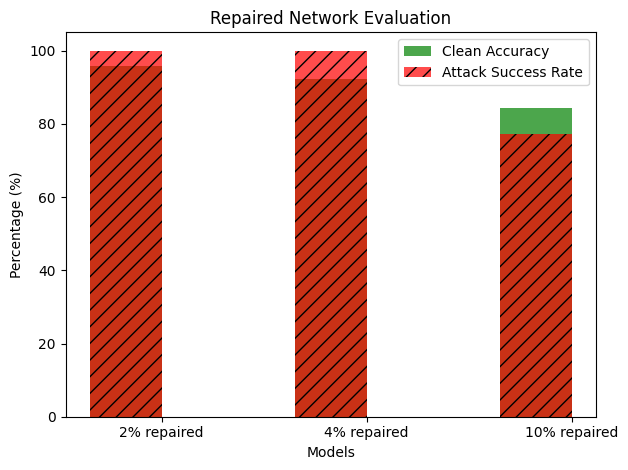

In [24]:
import matplotlib.pyplot as plt

# Define the data and labels
models = ["2% repaired", "4% repaired", "10% repaired"]
clean_accuracy = [accuracy_clean_repaired_2, clean_accuracy_repaired_4, clean_accuracy_repaired_10]
attack_success_rate = [attack_success_rate_repaired_2, attack_success_rate_repaired_4, attack_success_rate_repaired_10]

# Create subplots
fig, ax = plt.subplots()

# Set the width of the bars
bar_width = 0.35
index = range(len(models))

# Create bar plots for clean accuracy and attack success rate
bar1 = ax.bar(index, clean_accuracy, bar_width, label='Clean Accuracy', color='g', alpha=0.7)
bar2 = ax.bar(index, attack_success_rate, bar_width, label='Attack Success Rate', color='r', alpha=0.7, hatch='//')

# Set the x-axis labels
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(models)

# Set labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Percentage (%)')
ax.set_title('Repaired Network Evaluation')

# Add legends
ax.legend()

# Display the graph
plt.tight_layout()
plt.show()
